# Simulate a 1000 Genome Individual.
Idea: Create artifical Individual, that copies short diploid blocks, and sometimes haploid blocks
Record the start and end position of these runs.

Goal: Have a class in the end

Author: Harald Ringbauer

### Load Data
Load the data: All that is needed: Linkage Map as well as reference Haplotypes

In [1]:
import h5py   # For Processing HDF5s
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_h5(path):
        """Load and return the HDF5 File from Path"""
        f = h5py.File(path, "r")  # Load for Sanity Check. See below!
        print("\nLoaded %i variants" % np.shape(f["calldata/GT"])[0])
        print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
        # print(list(f["calldata"].keys()))
        # print(list(f["variants"].keys()))
        print(f"HDF5 loaded from {path}")
        return f

In [68]:
ch = str(3)
path1000G = "../Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr" + ch + ".hdf5"  # Path of 1000G (without chromosome part)
pop_path = "../Data/1000Genomes/integrated_call_samples_v3.20130502.ALL.panel" # Population Information

In [116]:
f = load_h5(path=path1000G)

list(f.keys())
list(f["variants"])
print(np.shape(f["calldata/GT"]))

### Load the Individual Names and merge in Population Data
meta_df = pd.read_csv(pop_path, sep="\t")

iids = np.array(f["samples"]).astype("str")
iids0 = np.char.split(iids, sep ='_', maxsplit=1) 
iids0 = [i[0] for i in iids0]
iid_df = pd.DataFrame({"sample":iids0})

meta_df = pd.merge(iid_df, meta_df[["sample", "pop", "super_pop"]], how="left", on="sample")

assert(len(meta_df)==len(iids)) # Sanity Cehck
print(f"Loaded {np.shape(meta_df)[0]} Population Data.")


Loaded 77658 variants
Loaded 503 individuals
HDF5 loaded from ../Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr3.hdf5
(77658, 503, 2)
Loaded 503 Population Data


### Create the Copying matrix
Imput: Only recombination Matrix
IIDs: Which individuals to copy from

Important parameters: Which individuals to copy from

Chunk Lengths

Beginning and end of ROH

### Step 1: Create chunked Individual

In [43]:
def create_chunked_gts(f, chunk_length, iids):
    """Create Chunked indiviual from Genotype Matrix f.
    Chunk_Lentgh: Length of the chunking
    iids: The Individual IDs"""

    k = len(iids) # Nr of Individuals to copy from
    nr_loci, _, _ = np.shape(f["calldata/GT"])

    rec = np.array(f["variants/MAP"]).astype("float")  # Load Recombination Map in Morgan
    ch_min, ch_max = np.min(rec)-1e-10, np.max(rec)

    nr_chunks = np.ceil((ch_max - ch_min) / chunk_length).astype("int")
    copy_id = np.random.randint(k, size=nr_chunks)  # Create all copying indices

    len_bins = np.arange(ch_min, ch_max, chunk_length)  # Create Length Bin Vector 
    len_bins = np.append(len_bins, ch_max)  # Append the last Value

    print("Setting new Genotypes...")
      
    gts_new = -np.ones((2, nr_loci)) # Initialize with invalid Value

    for i in range(len(len_bins)-1):  # Iterate over all Length Bins
        c_min, c_max = len_bins[i], len_bins[i+1]

        i_min, i_max = np.searchsorted(rec, [c_min, c_max])
        #print((i_min, i_max))
        ind = copy_id[i]
        gts_new[1, i_min:i_max+1] = f["calldata/GT"][i_min:i_max+1, ind, 0]
        gts_new[0, i_min:i_max+1] = f["calldata/GT"][i_min:i_max+1, ind, 1]  
    print("Finished")
    
    assert(nr_loci == len(rec)) # Sanity Check
    assert(np.min(gts_new)>-1)  # Sanity Check    
    return gts_new, rec

In [44]:
chunk_length = 0.005   # Chunk Length [in Morgan]
iids = np.arange(100)

gts_new, rec = create_chunked_gts(f, chunk_length, iids)

Setting new Genotypes...
Finished


### Step 2: Copy in ROH

In [61]:
# Locations of ROH
def copy_in_roh(f, gts, roh_begin, roh_end, id_copy):
    """Copy In ROH Block.
    f: HDF where to copy from
    gts: 2xn Matrix of Genotypes to copy ROH block in
    id_copy: Integer Index of which Individual to copy from
    roh_begin, roh_end: Start and End of Block to copy from [in Morgan].
    Return: Genotype Matrix"""

    rec = np.array(f["variants/MAP"]).astype("float")  # Load Recombination Map in Morgan
    i_min, i_max = np.searchsorted(rec, [roh_begin, roh_end])  # Get the Indices where to begin and end ROH

    print(f"Copying in Block: {rec[i_min]:.4f}-{rec[i_max]:.4f} M")
    print(i_min)
    
    assert(np.shape(gts)[1] == len(rec)) # Sanity Check
    
    gts_copy = f["calldata/GT"][i_min:i_max+1, id_copy, 1] # The Stretch to copy in
    gts[:, i_min:i_max+1] = gts_copy[None, :] # Copy in the Stretch
    
    return gts

In [117]:
roh_begin = 0.5 # Where to insert the ROH
roh_end = 0.55
id_copy = 101  # ID where to copy from

gts_roh = copy_in_roh(f, gts_new, roh_begin, roh_end, id_copy)  

Copying in Block: 0.5000-0.5502 M
14427


### Downsample to real Individual
Various Downsampling as well as error Models

### Save the artificial Individual

### Create new HDF5

# Area 51

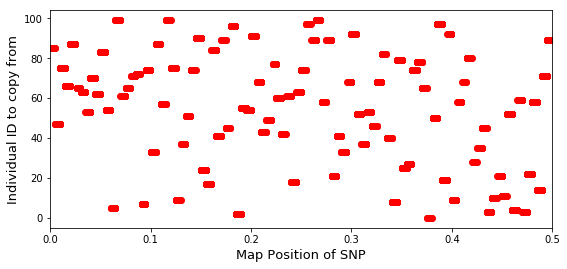

In [15]:
plt.figure(figsize=(9,4))
plt.plot(rec, copy_ind, "ro")
plt.xlabel("Map Position of SNP", fontsize=13)
plt.ylabel("Individual ID to copy from", fontsize=13)
plt.xlim([0,0.5])
plt.show()

In [33]:
np.shape(gts_new)

(2, 77658)

## Extract Individuals

In [105]:

#meta_df["pop"]